##**Comic Book Cover Generator Using GAN Architecture**

We are going to work with the same high-res images of a bunch of manga comicbook covers. We are going to setup a generative adversarial network, to create synthetic comic book covers (ideally ones that look real).

# Import Dataset

In [72]:
import pandas as pd
from google.colab import files
import io

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The shape if each image is (584, 416, 3).


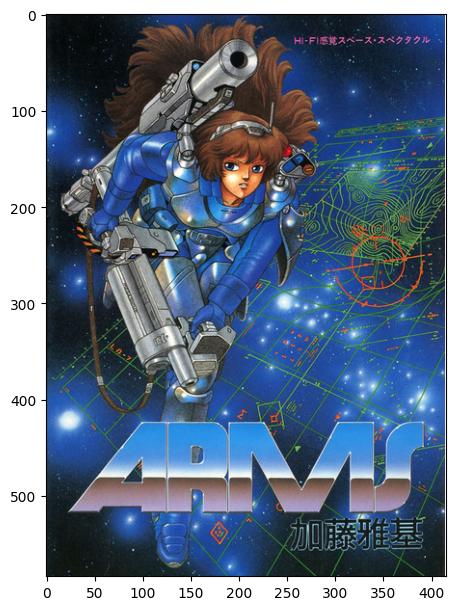

We have 107 images.


In [78]:
import numpy as np
import glob
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

image_list = []
for file in glob.glob("/content/drive/My Drive/Teaching/Courses/BA 865/BA865-2022/Week 5/datasets/manga_low/*"):
    im=Image.open(file)
    # I am stripping off the last row.
    img_array = np.array(im)[:-1,:,:]
    # Then I am adding two columns of white pixels. Why
    white = np.ones(shape=(584,2,3))*255
    img_array = np.hstack([img_array,white])  
    img_array = np.divide(img_array,255)
    image_list.append(img_array)

dpi = 80
  
height, width, depth = image_list[0].shape
figsize = width / float(dpi), height / float(dpi)

print(f'The shape if each image is {image_list[0].shape}.')

plt.figure(figsize=figsize)
plt.imshow(image_list[0])
plt.show()

print(f'We have {len(image_list)} images.')

# Create Our GAN Architecture

Now, we just need to create a model that takes the pixelated image as input, and tries to predict the original. 

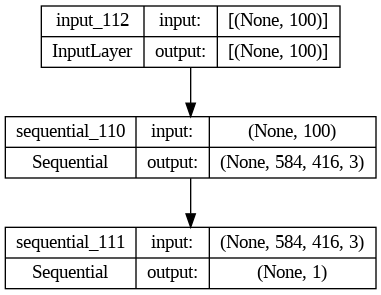

In [74]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

dense_output = (36,26,16)

# The generator network 
# This network will take a 100-element long random vector as input and create an image based on it.
generator = keras.Sequential([
    layers.Input(shape=(100,)),
    layers.Dense(dense_output[0] * dense_output[1] * dense_output[2], activation='relu',name="generator_dense"),
    layers.Reshape(dense_output),
    layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    # This makes us get the correct shape of output.
    layers.ZeroPadding2D(((8, 0), (0, 0))),
    layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='tanh')
])

# The discriminator network takes images as input (whether real or generated ones) and tries to predict their authenticity.
discriminator = keras.Sequential([
    layers.Input(shape=(584,416,3)),
    layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',activation="LeakyReLU"),
    layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same',activation="LeakyReLU"),
    layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same',activation="LeakyReLU"),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid',name="discriminator_output")
])

# Discriminator predicts a label (is it real or is it fake, hence binary_crossentropy loss makes sense)
discriminator.compile(optimizer="adam", loss='binary_crossentropy')

# The generator is producing image output that *maximizes* the discriminator's error
generator.compile(optimizer="adam", loss='binary_crossentropy')

# Okay, now that we have our generator and our discriminator, we can define the larger GAN, which wraps both networks. 
# At each step, we are going to first train the discriminator, to make it better at distinguishing between real and synthetic images.
# Next, we will do a training iteration on the GAN, temporarily freezing the discriminator's weights. 
# This will mean we only will update the generator's weights. 
# In this way, during training, we will alternate back and forth between making the discriminator better at its job, then the generator better at its job.
z = layers.Input(shape=(100,))

# Now we define the larger GAN that incorporates both the discriminator and generator. 
# The GAN attempts to maximize the performance of the discriminator in correctly classifying synthetic output.
gan_input = layers.Input(shape=(100,))
img = generator(gan_input)
discriminator.trainable = False
gan_output = discriminator(img)

# The GAN should always try to predict zeroes 0 (fake) which means we want to minimize cross-entropy loss. 
gan = keras.Model(gan_input, gan_output)

gan.compile(loss='binary_crossentropy', optimizer="adam")

#keras.utils.plot_model(generator, show_shapes=True)
#keras.utils.plot_model(discriminator, show_shapes=True)
keras.utils.plot_model(gan,show_shapes=True)

Okay, let's try fitting this model... 

In [79]:
# Train the GAN
batch_size = 107
epochs = 10000
real_images = np.stack(image_list, axis=0)

num_batches = real_images.shape[0] // batch_size

We are now manually implementing batches and epochs in our training process for the GAN...

In [ ]:
for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1, epochs))
    
    for batch in range(num_batches):
        # Select a random batch of real images
        image_batch = real_images[batch*batch_size:(batch+1)*batch_size]

        # Generate a batch of synthetic images using the generator
        generator_input = np.random.normal(0, 1, (batch_size, 100))
        synthetic_images = generator.predict(generator_input)

        # Create labels for real and synthetic images
        real_labels = np.ones((batch_size, 1))
        synthetic_labels = np.zeros((batch_size, 1))

        # Train the discriminator on a batch of real images, then again on a batch of synthetic images
        d_loss_real = discriminator.train_on_batch(image_batch, real_labels)
        d_loss_synthetic = discriminator.train_on_batch(synthetic_images, synthetic_labels)

        # Discriminator loss is the average of its loss across real and synthetic image sets. 
        # The idea here is that we want it to make as few mistakes as possible (this is intuitive I think)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_synthetic)

        # Now update the generator to encouage it to produce synthetic images that the discriminator incorrectly classifies as real.
        generator_input = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(generator_input, real_labels)

        # Print loss for this batch
        print("Batch {}/{} - Discriminator loss: {}, Generator loss: {}".format(batch+1, num_batches, d_loss, g_loss))

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 27ms/step
Batch 1/1 - Discriminator loss: 4.3904357927004867e-10, Generator loss: 22.617191314697266
Epoch 8335/10000
4/4 [==============================] - 0s 27ms/step
Batch 1/1 - Discriminator loss: 1.1834893065554297e-09, Generator loss: 21.83694076538086
Epoch 8336/10000
4/4 [==============================] - 0s 27ms/step
Batch 1/1 - Discriminator loss: 2.0223314134426573e-09, Generator loss: 22.209121704101562
Epoch 8337/10000
4/4 [==============================] - 0s 27ms/step
Batch 1/1 - Discriminator loss: 1.1171800151643652e-09, Generator loss: 21.607290267944336
Epoch 8338/10000
4/4 [==============================] - 0s 27ms/step
Batch 1/1 - Discriminator loss: 1.0066172340117419e-09, Generator loss: 22.21467399597168
Epoch 8339/10000
4/4 [==============================] - 0s 27ms/step
Batch 1/1 - Discriminator loss: 5.773272415687813e-10, Generator loss: 22.98269271850586
Epoch 8340

Let's now see some of synthetic images that our generator can produce.

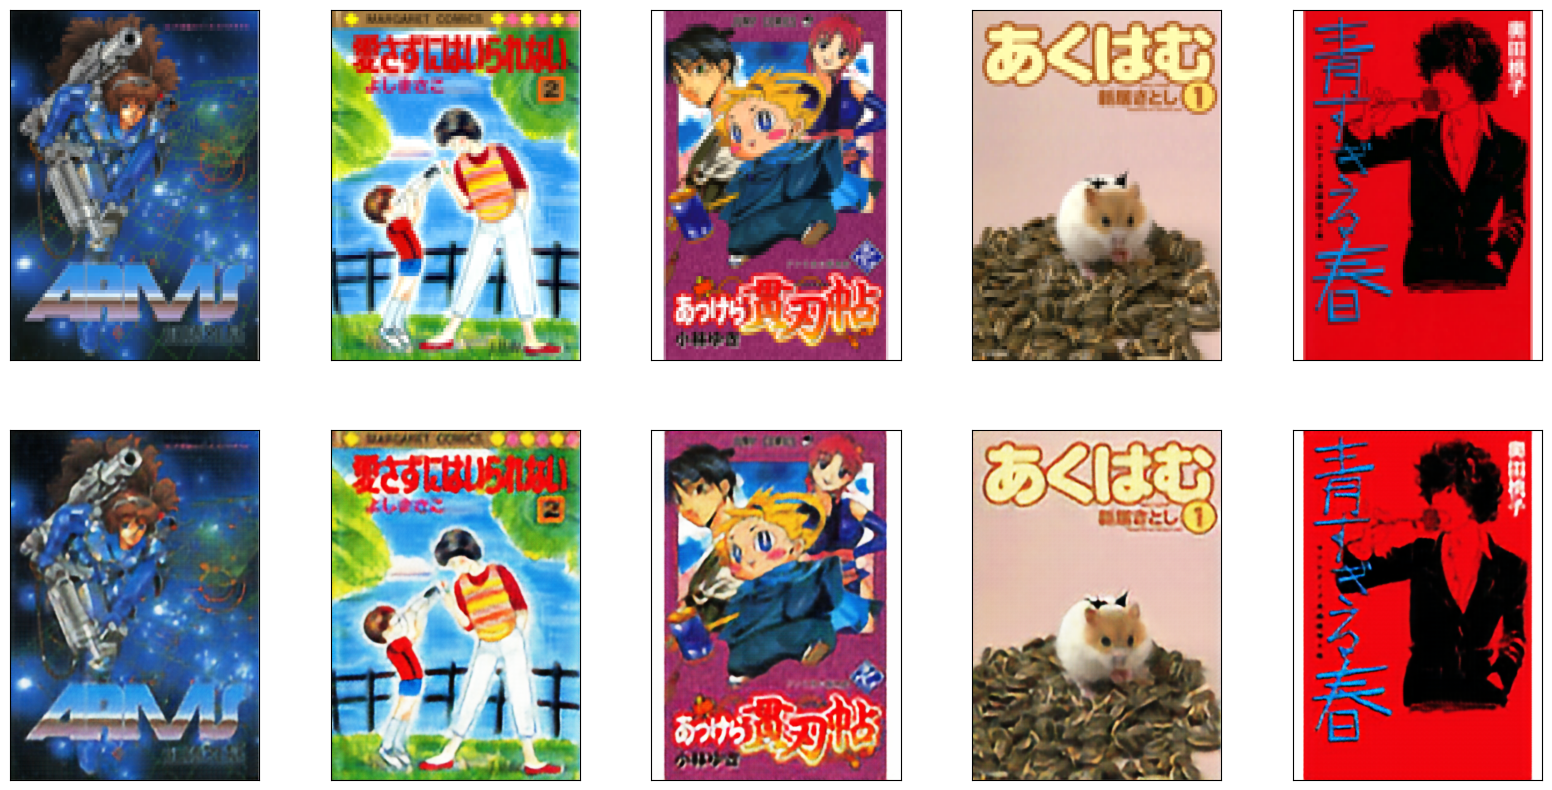

In [ ]:
n = 5
plt.figure(figsize= (20,5))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow((generator.predict(np.random.normal(0, 1, (1, 100)))).astype('uint8'))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()